<div class="output_png output_subarea output_execute_result">
<center>
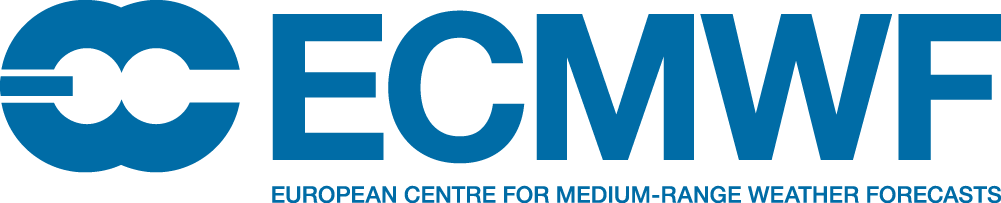
</div>

# 	Wind and geopotential at various pressure levels

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-uv-z  


<div class="output_png output_subarea output_execute_result">
<center>
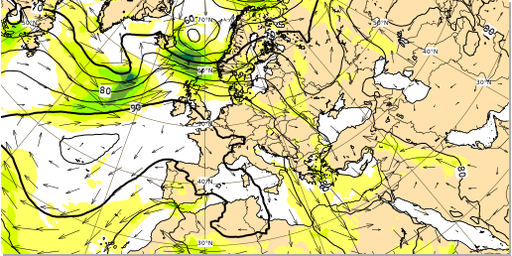</center>
</div>

The full list of available Open data products can be found [here](https://www.ecmwf.int/en/forecasts/datasets/open-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/DAC/ECMWF+open+data%3A+real-time+forecasts).  
This product takes in input 3 parameters :

* [U component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=131)
* [V component of wind](https://apps.ecmwf.int/codes/grib/param-db/?id=132)
* [Geopotential height](https://apps.ecmwf.int/codes/grib/param-db/?id=156)

at different pressure levels.

In this example, we will use: 
- [**ecmwf.opendata**](https://github.com/ecmwf/ecmwf-opendata) Client to download the data
- [**ecmwf.data**](https://github.com/ecmwf/ecmwf-data) library to read and process the data 
- [**magpye**](https://magpye.readthedocs.io) to plot the result

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-data ecmwf-opendata magpye

In [1]:
import ecmwf.data as ecdata
from magpye import GeoMap
from ecmwf.opendata import Client

In [2]:
client = Client("ecmwf", beta=True)

In [3]:
parameters = ['gh', 'u', 'v']
filename = 'medium-uv-z.grib'
filename

'medium-uv-z.grib'

Setting date to 0 will download today's data. 
Removing date and time altogether from the request will download the latest data.  
Try commenting out date and time to download latest forecast!

In [4]:
client.retrieve(
    date=0,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[1000,925,850,700],
    param=parameters,
    target=filename
)

## Reading and processing the data
Now we can use **ecmwf.data** to read the file.

In [5]:
data = ecdata.read(filename)

The **describe()** function will give us the overview of the dataset.  
We can see that we have a mixture of surface level and pressure level parameters.

In [6]:
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,"700,850,...",20220428,0,12,None,156,od,oper,fc,0001
u,isobaricInhPa,"700,850,...",20220428,0,12,None,131,od,oper,fc,0001
v,isobaricInhPa,"700,850,...",20220428,0,12,None,132,od,oper,fc,0001


And specifying the parameter shortName in the describe function, we can get more detailed information about the data.

In [7]:
data.describe('gh')

shortName,gh
name,Geopotential height
paramId,156
units,gpm
typeOfLevel,isobaricInhPa
level,"700,850,925,1000"
date,20220428
time,0
step,12
number,None
class,od


The grib file contains all the parameters and levels, and we will use the **select()** function to filter what we need.

In [8]:
u700 = data.select(shortName= 'u', level=700)
v700 = data.select(shortName= 'v', level=700)
gh700 = data.select(shortName='gh', level = 700)
gh700.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,700,20220428,0,12,None,156,od,oper,fc,0001


Geopotential height has units gpm (geopotential meters), but on the ECMWF Open charts it is plotted in geopotential decameters. To reproduce the plot we need to divide by 10.

In [9]:
gh700 /= 10

We can calculate the speed intensity using speed function.

In [10]:
speed = ecdata.speed(u700,v700)
speed.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
ws,isobaricInhPa,700,20220428,0,12,None,10,od,oper,fc,0001


And finally, we can plot the data on the map. 

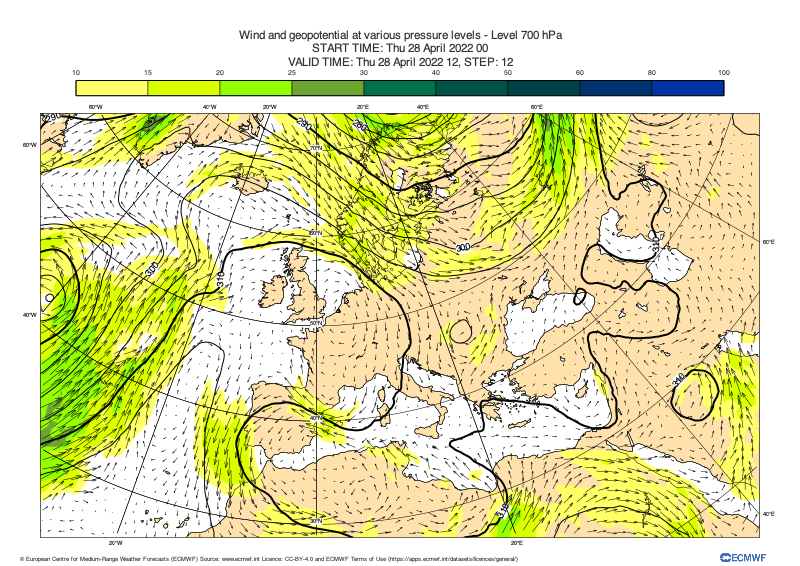

In [11]:
fig = GeoMap(area_name='europe')

fig.coastlines(land_colour="cream",resolution="medium")

fig.contour_shaded(speed, style="speed_green_low")
fig.contour_lines(gh700, style="black_i5")
fig.arrows(u=u700, v=v700, density=2, colour='black')

fig.coastlines(resolution="medium")
fig.gridlines()

fig.title(["Wind and geopotential at various pressure levels - Level <grib_info key='level' where='shortName=ws'/> hPa",
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=ws'/> ",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=ws'/>, STEP: <grib_info key='step' where='shortName=ws'/>"])

fig.legend()
fig.footer("© European Centre for Medium-Range Weather Forecasts (ECMWF) Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use (https://apps.ecmwf.int/datasets/licences/general/)", logo='ecmwf')

fig.show()

Note that plot produced using open data dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
Open data is on 0.4x0.4 resolution, while high resolution data is 0.1x0.1 grid.